In [1]:
import warnings
# warnings.filterwarnings("ignore")


import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import numpy as np
import gym
from tqdm import tqdm

import matplotlib.pyplot as plt
import collections
import random

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [2]:
def prep(s): # inputs 210 x 160 x 3 and returns 105 x 80
    h = 210
    w = 160
    
    s = [[0.2989*s[2*i][2*j][0] + 0.5870*s[2*i][2*j][1] + 0.1140*s[2*i][2*j][2] for j in range(int(w / 2))] for i in range(int(h / 2))]
    
    return s


class Network(nn.Module):
    def __init__(self, input_dim, action_space, hidden_layers, activation_fn = nn.ReLU):
        super(Network, self).__init__()
        layers = [nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(8,8), stride=4), activation_fn()]
        layers.append(nn.Flatten())
        layers.append(nn.Linear( 1976, hidden_layers[0]))
        for i in range(len(hidden_layers) - 1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            layers.append(activation_fn())
        
        self.sequential = nn.Sequential(*layers)
        self.value_output = nn.Linear(hidden_layers[-1], 1)
        self.advantage_output = nn.Linear(hidden_layers[-1], action_space)
    
    def forward(self, x):
        state = x
        
        if not isinstance(state, torch.Tensor):
            if not(len(state) == 420):
                tw = [[[float(k) for k in j] for j in i] for i in state]
            else:
                tw = state

                



            state = torch.FloatTensor(tw)
            if len(state) == 72:
                state  = state.unsqueeze(1)
            else:
                state = state.unsqueeze(0)
        
        hidden_output = self.sequential(state)
        value_fn = self.value_output(hidden_output)
        advantage_fn = self.advantage_output(hidden_output)
        
        value_fn = value_fn.expand(advantage_fn.size())
        action_fn = value_fn + advantage_fn - advantage_fn.mean(-1, keepdim=True).expand(advantage_fn.size())
        return(action_fn)


In [3]:
class DuelingDQN():
    def __init__(self, env):
        self.env_name = env
        self.env = gym.make(env)
        self.state = self.env.reset()
        self.state = [12]
        self.online_model = Network(len(self.state), self.env.action_space.n, (512, 128))
        self.target_model = Network(len(self.state), self.env.action_space.n, (512, 128))
        self.target_model.load_state_dict(self.online_model.state_dict())
        
        #Hyperparameters
        self.epsilon = 0.6
        self.min_epsilon = 0.01
        self.decay = (self.epsilon - self.min_epsilon) / 2000
        self.gamma = 0.999
        self.tau = 0.03
        self.lr = 1e-4
        self.buffer_size = int(1e3)
        self.min_buffer_size = 100
        self.mini_batch_size = 72
        
        #Other variables
        self.optimizer = optim.Adam(self.online_model.parameters(), self.lr)
        self.loss_fn = nn.HuberLoss(delta=1.0)
        self.replay_buffer = collections.deque(maxlen=self.buffer_size)
        self.episode_scores = [0.0]
        
        self.eval_returns = []
    
    def optimise(self, experiences):
        states = [experience[0] for experience in experiences]
        actions = [experience[1] for experience in experiences]
        rewards = [experience[2] for experience in experiences]
        next_states = [experience[3] for experience in experiences] 
        is_terminals = [experience[4] for experience in experiences]
        
        action_values = self.online_model(np.array(states)).squeeze()
        idxs = torch.tensor(actions).long().unsqueeze(1)
        action_values = action_values.gather(1, idxs)
        
        with torch.no_grad():
            next_action_indices = np.array([self.online_model(a).detach() for a in next_states]).squeeze()
            next_action_indices = [ [next_action_indices[i][0][j] for j in range(4)] for i in range(72)]
            
            next_action_indices = np.argmax(next_action_indices, axis = 1)
            # print(next_action_indices)
            next_action_values = np.array([self.target_model(a).detach() for a in next_states]).squeeze()
            next_action_values = [next_action_values[p][0][next_action_indices[p]] for p in range(len(next_action_indices))]

            
        target = np.array(rewards) + self.gamma*np.array(next_action_values)*(1-np.array(is_terminals))
        
        target = torch.from_numpy(target).unsqueeze(1).float()
        
        loss = self.loss_fn(action_values, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step() 
        
    def step(self, optimise  = True, update = True):

        if random.random() <= self.epsilon or not(len(self.state) == 420):
            action = self.env.action_space.sample()
        else:
            with torch.no_grad():
                action_values = self.online_model(self.state).detach()
                action = int(torch.argmax(action_values.squeeze()))
        
        ns = []
        i = 0
        

        while i<4:
            mew, reward, terminated, info = self.env.step(action)
            
            mew = prep(mew)
            for x in mew:

                ns.append(x)
                
            self.episode_scores[-1] += reward

            i += 1
            
            
            if terminated:
                if len(ns) == 420 and len(self.state) == 420:
                    self.replay_buffer.append((self.state, action, reward, ns, terminated))
                self.state = self.env.reset()
                self.state = [12]
                self.episode_scores.append(0.0)
                break


         
        
        
        self.epsilon = max(self.epsilon - self.decay, self.min_epsilon)
        next_state = ns

        if len(next_state) == 420 and len(self.state) == 420:
                self.replay_buffer.append((self.state, action, reward, next_state, terminated))
            
        self.state = next_state
            
        if optimise and len(self.replay_buffer) >= self.min_buffer_size:
            self.optimise(random.sample(self.replay_buffer, k = self.mini_batch_size))
        
        if update:
            for target_param, online_param in zip(self.target_model.parameters(), self.online_model.parameters()):
                target_param.data.copy_(self.tau*online_param.data + (1.0-self.tau)*target_param.data)
    
    # def eval_model(self, render):
    #     with torch.no_grad():
    #         eval_env = gym.make(self.env_name, render_mode = "human" if render else None)
    #         eval_episodes = 10
    #         for episode in range(eval_episodes):
    #             state = prep(eval_env.reset()[0])
    #             done = False
    #             total_return = 0
    #             while not done:
    #                 action_values = self.online_model(state)
    #                 action = int(torch.argmax(action_values.squeeze()))
    #                 next_state, reward, terminated, truncated , info = eval_env.step(action)
    #                 next_state = prep(next_state)
    #                 if render:
    #                     eval_env.render()
    #                 done = terminated or truncated
                    
    #                 total_return += reward
    #                 state = next_state
    #             self.eval_returns.append(total_return)
    #         return np.mean(self.eval_returns[len(self.eval_returns) - eval_episodes: ])
    
    def plot_results(self):
        plt.plot(range(len(self.episode_scores)), self.episode_scores)
        plt.xlabel("Episode")
        plt.ylabel("Score")
        plt.show()
                
    def train(self, time_stamps, eval_time_stamps, plot_time_stamps):
        for time_stamp in tqdm(range(1, time_stamps + 1)):
            self.step()
            
            # if(time_stamp % eval_time_stamps) == 0:
            #     if self.eval_model(False) > 480.0:
            #         print("Solved CartPole with final average greater than 480 across 10 episodes")
            #         self.plot_results()
            #         break
            
            if(time_stamp % plot_time_stamps) == 0:
                self.plot_results()


A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]
  3%|▎         | 102/4000 [00:13<09:00,  7.22it/s]/tmp/ipykernel_1022/4258649513.py:42: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  next_action_indices = np.array([self.online_model(a).detach() for a in next_states]).squeeze()
/tmp/ipykernel_1022/4258649513.py:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when 

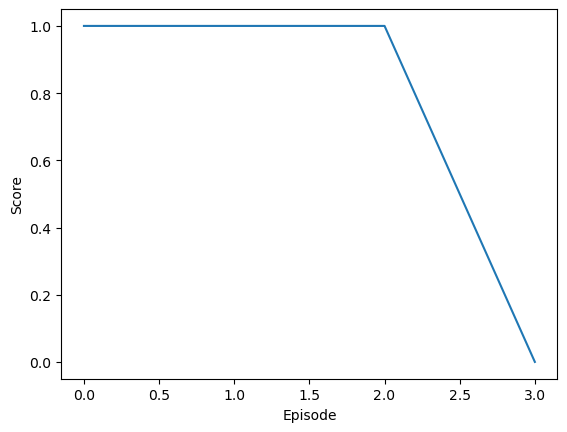

 10%|▉         | 399/4000 [03:19<36:44,  1.63it/s]

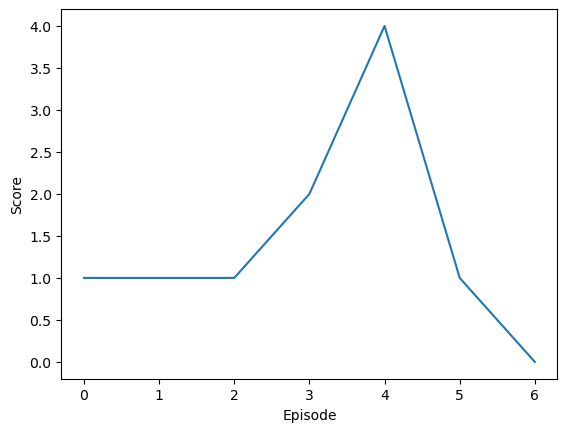

 15%|█▍        | 599/4000 [05:26<37:47,  1.50it/s]

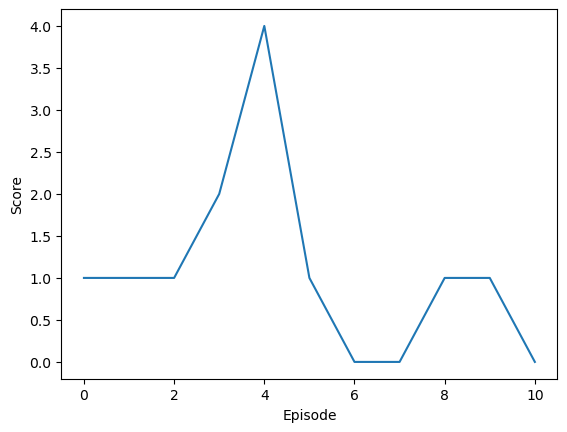

 20%|█▉        | 799/4000 [07:33<35:19,  1.51it/s]

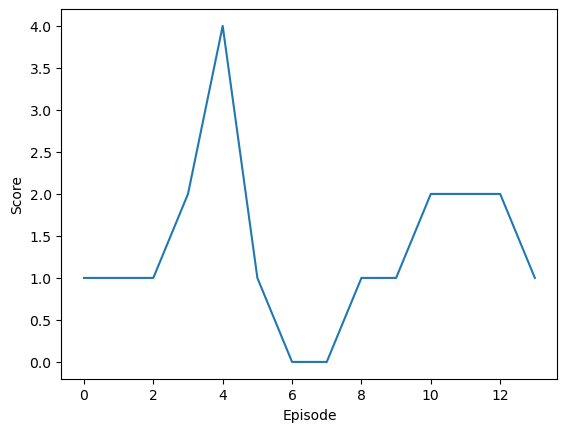

 25%|██▍       | 999/4000 [09:39<33:13,  1.51it/s]

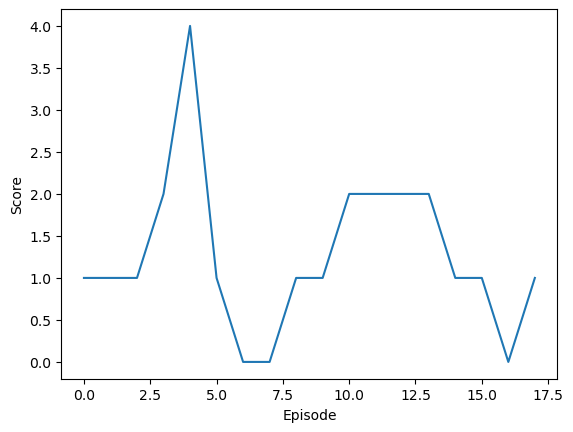

 30%|██▉       | 1199/4000 [11:42<27:22,  1.71it/s]

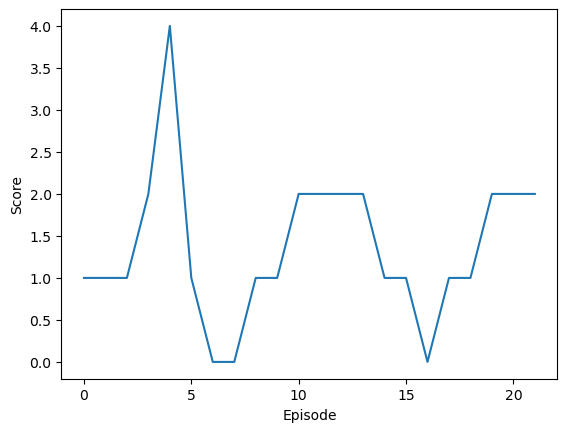

 35%|███▍      | 1399/4000 [13:47<26:54,  1.61it/s]

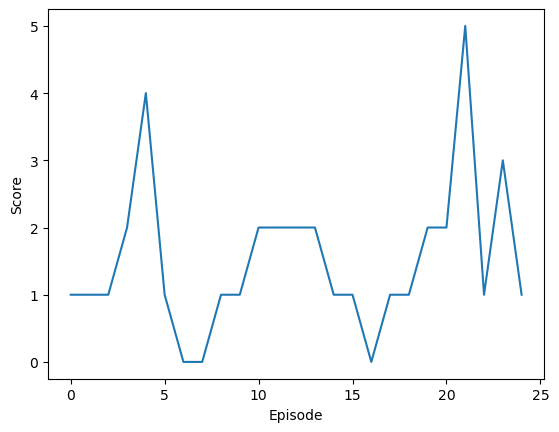

 40%|███▉      | 1599/4000 [15:52<23:28,  1.70it/s]

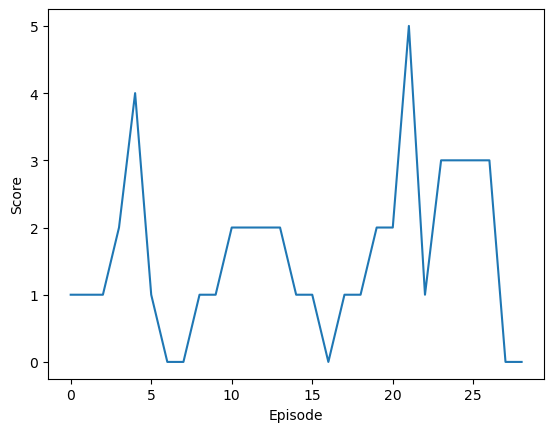

 45%|████▍     | 1799/4000 [17:56<21:47,  1.68it/s]

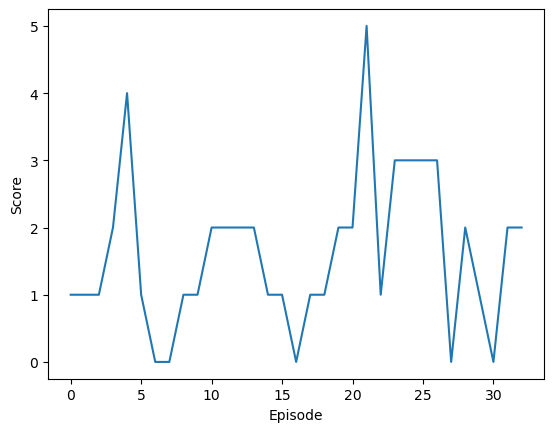

 50%|████▉     | 1999/4000 [20:04<22:47,  1.46it/s]

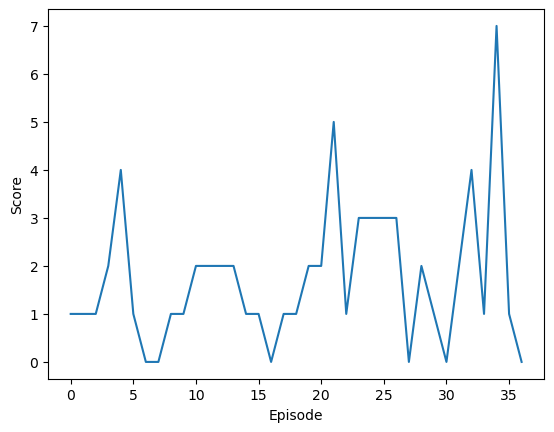

 55%|█████▍    | 2199/4000 [22:12<18:05,  1.66it/s]

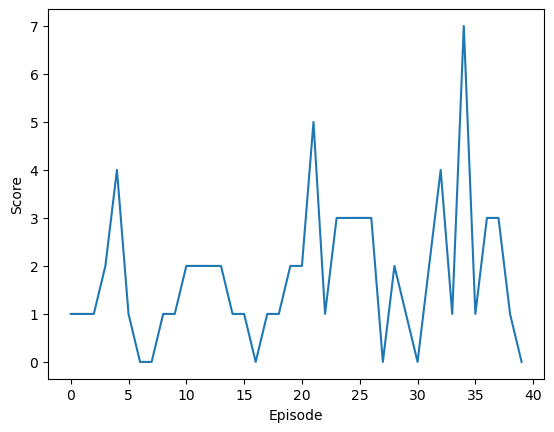

 60%|█████▉    | 2399/4000 [24:31<19:04,  1.40it/s]

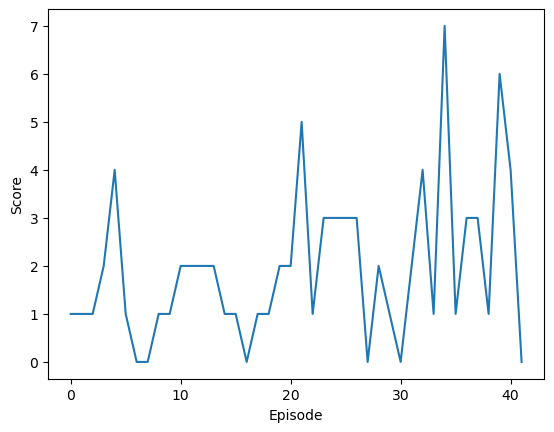

 65%|██████▍   | 2599/4000 [26:47<16:00,  1.46it/s]

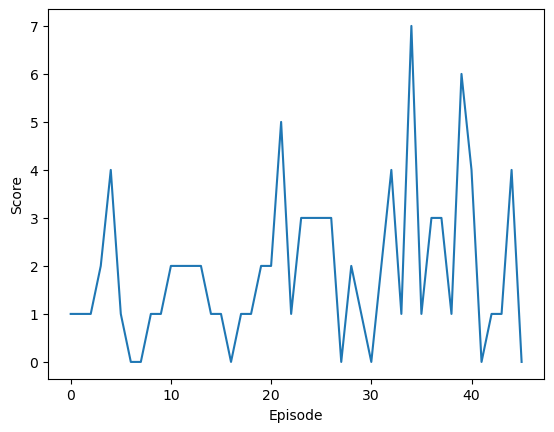

 70%|██████▉   | 2799/4000 [29:01<12:45,  1.57it/s]

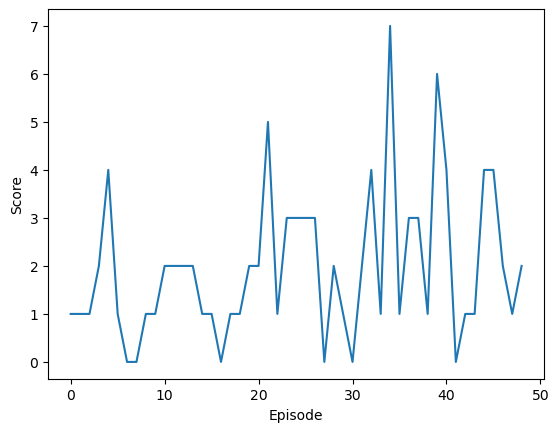

 75%|███████▍  | 2999/4000 [31:16<11:34,  1.44it/s]

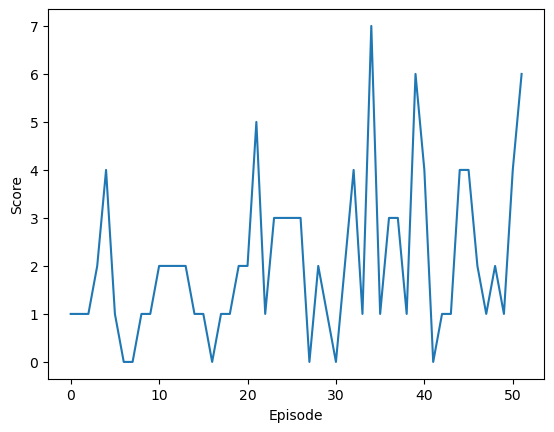

 80%|███████▉  | 3199/4000 [33:31<09:50,  1.36it/s]

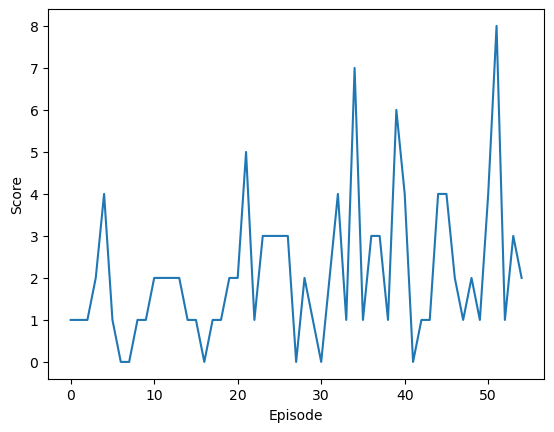

 85%|████████▍ | 3399/4000 [35:48<06:38,  1.51it/s]

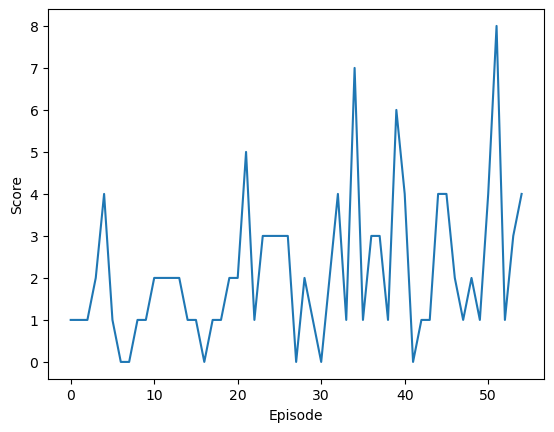

 90%|████████▉ | 3599/4000 [38:04<04:44,  1.41it/s]

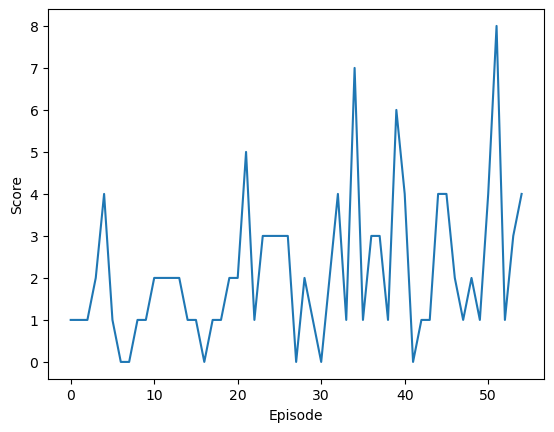

 95%|█████████▍| 3799/4000 [40:20<02:27,  1.36it/s]

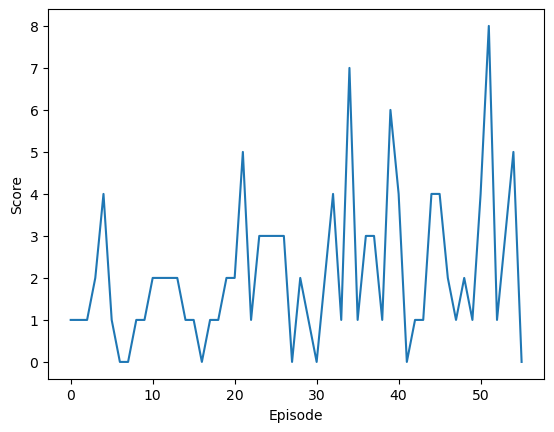

100%|█████████▉| 3999/4000 [42:38<00:00,  1.53it/s]

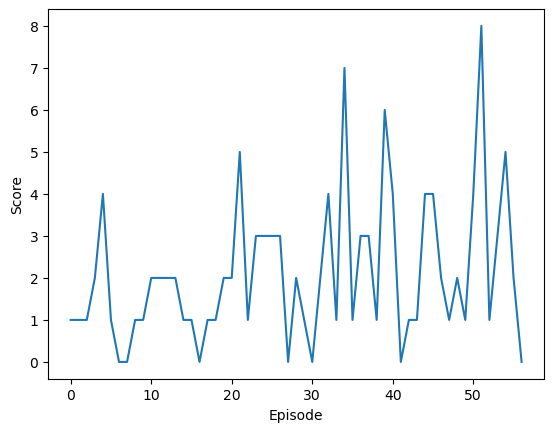

100%|██████████| 4000/4000 [42:38<00:00,  1.56it/s]


In [4]:
agent = DuelingDQN("ALE/Breakout-v5")
agent.train(4000, 250, 200)

torch.save(agent.online_model, "model1.pth")

In [21]:
print(np.average(agent.episode_scores[:10]))
print(np.average(agent.episode_scores[50:]))

1.2
3.2857142857142856


As clearly visible, there is a significant development of the results of the agent from the initial untrained version to that in the later stages